# 前置作業

## 套件

In [ ]:
# 常用、基本
import os
import pandas as pd
import numpy as np

# 畫圖
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 建模
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 評估
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
import seaborn as sns
# cm = sns.light_palette("green", as_cmap=True)
cm = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True) # ref: https://seaborn.pydata.org/generated/seaborn.light_palette.html#seaborn.light_palette

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [ ]:
docu_root = '/content/gdrive/MyDrive/Colab Notebooks/'

## 資料集
- 資料集：[Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
- 這份資料及目的是要預測是否中風，並存在類別不平衡問題，需要再進一步處理
- 這份程式碼主要是給大家簡略參考機器學習流程，所以方法只用一兩種而已

In [ ]:
df = pd.read_csv(docu_root + 'datasets/healthcare-dataset-stroke-data.csv')

### 觀察資料集

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 資料維度
df.shape

(5110, 12)

In [ ]:
# 資料基本資訊
# 查看欄位名稱及其型態、是否有欄位缺失
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


df.describe()
- 通常在結構化資料中最簡單去觀察資料的做法
- 對文字型的資料比較沒意義，但用在數值型資料上就會有標準差、平均數等基本指標

In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**目標變數的類別分布**

* 若太過不平均，會導致類別不平衡（imbalance）的問題，發生這種情況通常需透過其他方式處理，通常分成undersampling和oversampling
（e.g. SMOTE、ADASYN）

### solution 1：pandas

In [ ]:
temp = df['stroke'].value_counts().reset_index().rename(columns={'stroke':'count', 'index':'stroke'})
temp

,stroke,count
0,0,4861
1,1,249


### solution 2：長條圖

<Axes: xlabel='stroke', ylabel='count'>

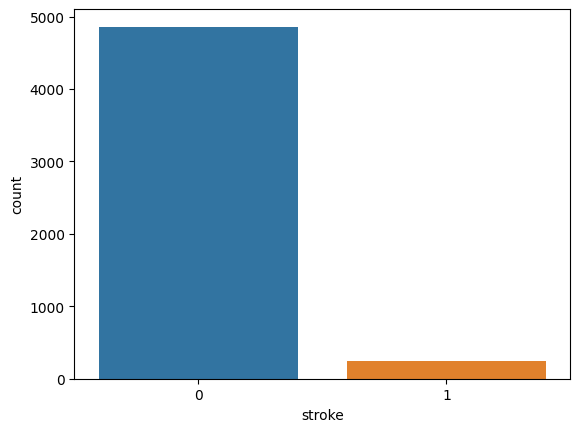

In [ ]:
sns.countplot(x='stroke', data=df)

# 資料前處理

## 資料清洗

通常處理缺失值、重複值或是異常值（e.g. 數值中有些特別大或特別小的值，只有數值型資料存在異常值）

### 缺失值處理
以這個資料及為例，在觀察資料集這個部分可以看到bmi這個欄位存在NaN


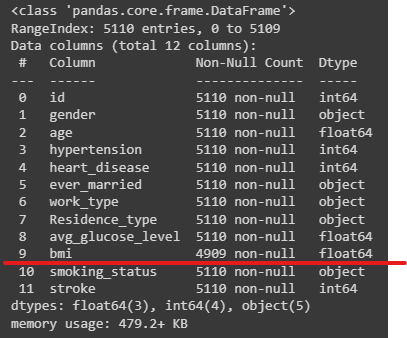

In [ ]:
# 直接丟棄缺失值因為存在類別不平恆，盡量保留資料
# df = df.dropna()

In [ ]:
# 將缺失值填入整體平均值
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(value=mean_bmi, inplace=True)

In [ ]:
# 去除id
df = df.drop('id', axis = 1)

## 資料標籤化

將非數值型資料轉換成數值，才能傳送給機器學習演算法進行處理

In [ ]:
# 找出所有非數值型資料
cols = df.select_dtypes(exclude=[np.number]).columns
cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:
# 用一個迴圈將所有非數值型資料都做encoder
for i in cols:
  df[i] = labelencoder.fit_transform(df[i])
  print('[{}]特徵對照：'.format(i),end='')
  for j in range(len(labelencoder.classes_)):
    print('{}-{}'.format(j, labelencoder.classes_[j]),end=', ')
  print()

df

[gender]特徵對照：0-Female, 1-Male, 2-Other, 
[ever_married]特徵對照：0-No, 1-Yes, 
[work_type]特徵對照：0-Govt_job, 1-Never_worked, 2-Private, 3-Self-employed, 4-children, 
[Residence_type]特徵對照：0-Rural, 1-Urban, 
[smoking_status]特徵對照：0-Unknown, 1-formerly smoked, 2-never smoked, 3-smokes, 


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


## 資料標準化

這邊就示範標準化的其中一種方法

In [ ]:
# 選擇要進行標準化的特徵欄位
selected_features = ['age', 'avg_glucose_level', 'bmi']


In [ ]:
# 將數值資料轉成 Z_score
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
temp_df = df[selected_features]
arr = std.fit_transform(temp_df)
df[selected_features] = arr
df
# age	hypertension	heart_disease	avg_glucose_level	bmi	stroke	Sex	Residency	Smoker

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.051434,0,1,1,2,1,2.706375,1.001234e+00,1,1
1,0,0.786070,0,0,1,3,0,2.121559,4.615554e-16,2,1
2,1,1.626390,0,1,1,2,0,-0.005028,4.685773e-01,2,1
3,0,0.255342,0,0,1,2,1,1.437358,7.154182e-01,3,1
4,0,1.582163,1,0,1,3,0,1.501184,-6.357112e-01,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1.626390,1,0,1,2,1,-0.494658,4.615554e-16,2,0
5106,0,1.670617,0,0,1,3,1,0.420775,1.442949e+00,2,0
5107,0,-0.363842,0,0,1,3,0,-0.511443,2.217363e-01,2,0
5108,1,0.343796,0,0,1,2,0,1.328257,-4.278451e-01,1,0


In [ ]:
df = df.drop(['ever_married','work_type'], axis=1)

## 切割資料
* 先把資料集切成自變數（X）和目標變數（y）
* 在分成7:3（訓練集和測試集）


In [ ]:
X = df.drop('stroke', axis = 1)
y = df['stroke']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                        X, y,
                        test_size=0.3, random_state=88)

## 畫圖

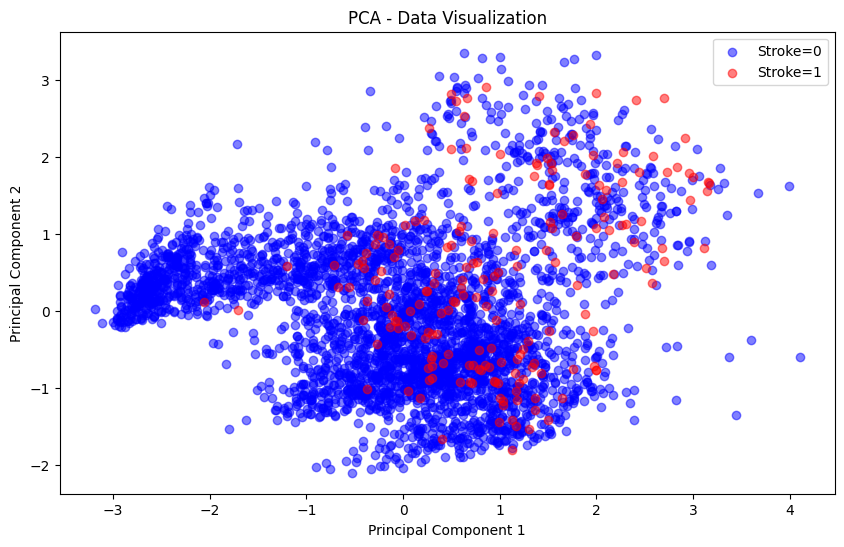

In [ ]:
from sklearn.decomposition import PCA

def pca_draw(df, y):
  n_components = 2  # 這裡選擇保留2個主成分
  pca = PCA(n_components=n_components)

  X_pca = pca.fit_transform(df)

  pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])

  # y_train合併
  pca_df['stroke'] = y.values

  plt.figure(figsize=(10, 6))
  colors = ['blue', 'red']
  for stroke, color in zip([0, 1], colors):
      plt.scatter(
          pca_df[pca_df['stroke'] == stroke]['PC1'],
          pca_df[pca_df['stroke'] == stroke]['PC2'],
          color=color,
          alpha=0.5,
          label=f'Stroke={stroke}'
      )
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title('PCA - Data Visualization')
  plt.legend()
  plt.show()

pca_draw(X_train, y_train)

## 類別不平衡處理

因為只是要示範流程，這裡只做了簡單的SMOTE處理

‼️注意：類別不平衡處理一定要在切分資料集後操作，因為執行重採樣可能會產生假資料，不可污染到測試集

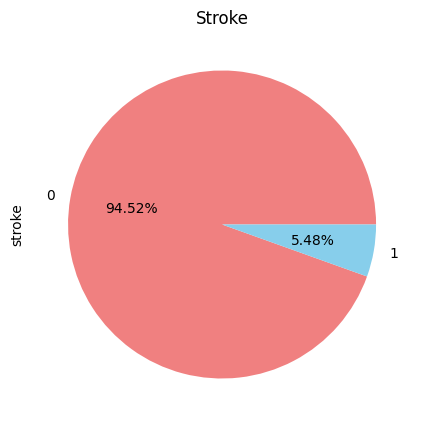

In [ ]:
# 先畫圖查看類別分佈
plt.figure( figsize=(10,5) )
y_train.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%', labels = [0,1] )
plt.title('Stroke')  # 圖標題
plt.show()

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)

In [ ]:
# Tomek link
# from imblearn.under_sampling import TomekLinks
# tomek_links = TomekLinks(sampling_strategy='all')
# X_train_SMOTE, y_train_SMOTE = tomek_links.fit_resample(X_train_SMOTE, y_train_SMOTE)

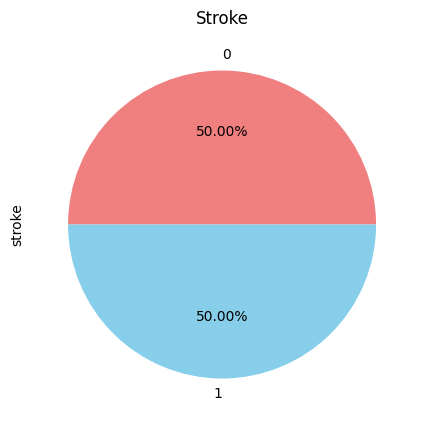

In [ ]:
# 畫圖重新查看過採樣後的類別分佈
plt.figure( figsize=(10,5) )
y_train_SMOTE.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%', labels = [0,1] )
plt.title('Stroke')  # 圖標題
plt.show()

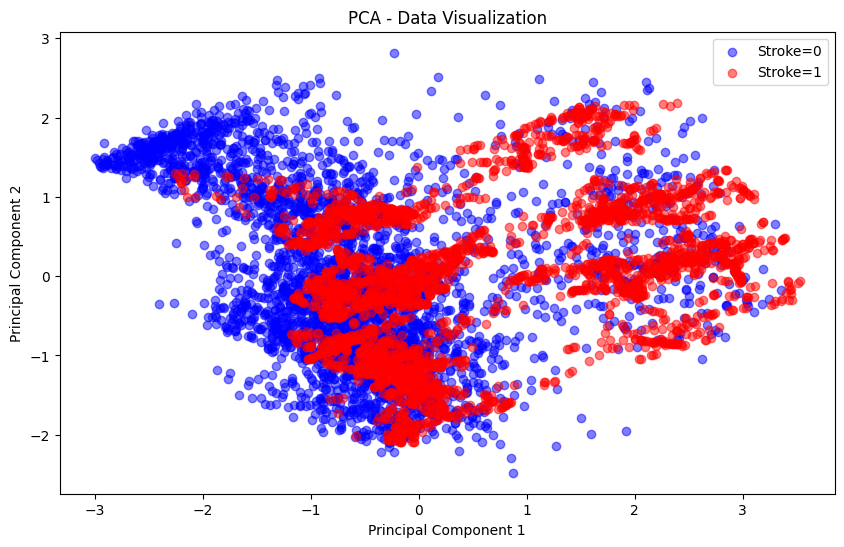

In [ ]:
pca_draw(X_train_SMOTE, y_train_SMOTE)

## 補充:用於文字的前處理

如果今天資料集包含文字的話通常需要更多更複雜的前處理

清理資料：轉小寫、去除標點符號、停用字、字根還原等

文本特徵轉化：詞袋模型（BoW）、TF-IDF、Word2Vec或是常聽過的BERT等的

# 建模

模型大多都有許多參數可以使用，這些參數都很重要
1. 在建模時最好要去看每個模型的參數，不用真的背起來，至少看過有印象後，模型需要調整東西會比較有幫助
2. 此次任務主要是想帶一個完整流程，故沒有額外細講個別模型的參數，這些資訊通常都會列在套件的documentation，再不然也可查看網路教學
3. 以下選用了三個機器學習模型可以比較一下此資料集更適合哪個分類器。

備註：ML Model中，常用的[XGBoost](https://xgboost.readthedocs.io/en/stable/)、Random Forest、SVM等

## SVM

SVM的目標是找到一個最佳的超平面，使得兩個不同類別的樣本距離該平面最遠，常用於分類任務



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
clf = SVC(kernel='linear', random_state=0)
clf.fit(X_train_SMOTE, y_train_SMOTE)

SVC(kernel='linear', random_state=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1480
           1       0.09      0.77      0.16        53

    accuracy                           0.72      1533
   macro avg       0.54      0.75      0.50      1533
weighted avg       0.96      0.72      0.81      1533

AUC Score: 0.7479411014788374


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, min_samples_split=60)
rf.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(min_samples_split=60, n_estimators=10)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1480
           1       0.10      0.60      0.17        53

    accuracy                           0.80      1533
   macro avg       0.54      0.70      0.53      1533
weighted avg       0.95      0.80      0.86      1533

AUC Score: 0.7035759816420193


## LR

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_SMOTE,y_train_SMOTE)

LogisticRegression()

In [ ]:
y_pred = LR.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1480
           1       0.09      0.75      0.16        53

    accuracy                           0.73      1533
   macro avg       0.54      0.74      0.50      1533
weighted avg       0.96      0.73      0.82      1533

AUC Score: 0.7435747067822541
